In [51]:
# Makes report plot
# improt and define basic params
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from pathlib import Path
from os import listdir, path, makedirs
sns.set(style="darkgrid")
%matplotlib inline

# Calibrated data dir
calibrated_base_dir = Path("..")/"../new_calibrate_full/"
min_stop_calibrated_base_dir = Path("..")/"../minstop_calibrate_full/"

# Class to use
import sys
sys.path.append("../../python")
from auditing_setup.election_setting import Election

from matplotlib import rc, rc_params
mpl.use('pdf')
plt.rc('font', family='serif', serif='Times')
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)
plt.rc('axes', labelsize=8)
mpl.rcParams["savefig.dpi"] = 200
sns.set(style="darkgrid")
sns.set(font_scale=1.2)
def toggle_tex(to=None):
    if to is not None:
        rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
        rc('text', usetex=to)
    elif mpl.rcParams['text.usetex']:
        rc('text', usetex=False)
    else:
        rc('text', usetex=True)
        
toggle_tex(to=False)

In [52]:
mpl.rcParams["figure.figsize"] = [8, 6]

In [53]:
def read_csv(file_path, sort_index=True, transpose=True):
    df = pd.read_csv(file_path, index_col=[0, 1])
    cols = []
    valid_cols = []
    for i in df.columns:
        try:
            cols.append(float(i))
            valid_cols.append(i)
        except Exception as e:
            pass
    df = df[valid_cols]
    df.columns = cols
    return df


def read_csv2(file_path, sort_index=True, transpose=True):
    df = pd.read_csv(file_path)
    cols = []
    for i in df.columns:
        try:
            cols.append(float(i))
        except Exception as e:
            cols.append(i)
    df.columns = cols
    df.index.set_names("election", inplace=True)
    df.set_index("legend", inplace=True)
    if sort_index:
        df.sort_index(inplace=True)
    if transpose:
        df = df.transpose()
    return df


def get_num_cols(df):
    cols = []
    for i in df.columns:
        try:
            float(i)
            cols.append(float(i))
        except Exception as e:
            pass
    return cols

def format_legend(ax=None, legend=None, how=0):
    if ax is not None:
        legend_ = ax.legend_
    elif legend is not None:
        legend_ = legend
    else:
        return
    
    for text in legend_.texts:
        if how == 0:
            raw = text.get_text()
            text.set_text(raw.replace(" | ", ", ").replace(" ", "").rsplit(",", 1)[0])
        elif how == 1:
            raw = text.get_text()
            print(raw.rsplit(",", 1)[0].replace("_", " "))
            text.set_text(raw.rsplit(",", 1)[0].replace("_", " "))
    return legend_

# Report Plots

In [54]:
def pivot_widetable(df, names, groupers, *args, **kwargs):
    df_long = df.melt(*args, **kwargs)
    for name, grouper in zip(names, groupers):
        group = [grouper(i) for i in df_long['variable']]
        df_long[name] = group
    return df_long

In [55]:
names = [
    'type'
    'basename'
    'basename_with_type'
    'parameter'
    'parameter_with_type'
]

basename_map = {'bayesian ': 'Bayesian',
                'max_sprt ': 'MaxBRAVO',
                'bravo    ': 'BRAVO',
                'clip     ': 'ClipAudit',
                'bravo_without_replacement ': 'BRAVO',
                'truncated_bayesian ': 'Bayesian (Least Favourable)',
                'bayesian_with_replacement ': 'Bayesian'}

type_map = {'bayesian ': 'BetaBinomial',
            'max_sprt ': '',
            'bravo    ': 'Binomial',
            'clip     ': '',
            'bravo_without_replacement ': 'Hypergeometric',
            'truncated_bayesian ': '',
            'bayesian_with_replacement ': 'Beta'}

basename_map_with_type = {'bayesian ': 'Bayesian (Uniform)',
                          'max_sprt ': 'MaxBRAVO',
                          'bravo    ': 'BRAVO (Binomial)',
                          'clip     ': 'ClipAudit',
                          'bravo_without_replacement ': 'BRAVO (Hypergeometric)',
                          'truncated_bayesian ': 'Bayesian (Least Favourable)',
                          'bayesian_with_replacement ': 'Bayesian (Beta)'}

def group_basename(name):
    name = name.split('|')[0]
    return basename_map[name]

def group_type(name):
    name = name.split('|')[0]
    return type_map[name]

def group_basename_with_type(name):
    name = name.split('|')[0]
    return basename_map_with_type[name]

def group_parameter(name):
    _, name = name.split('|', 1)
    name = name.rsplit('|', 1)[0] if len(name.rsplit('|', 1)) > 1 else ''
    name = name.replace('|', ',')
    name = name.replace(' ', '')
    return name

def group_parameter_with_type(name):
    _, name = name.split('|', 1)
    type = group_type(_)
    name = name.rsplit('|', 1)[0] if len(name.rsplit('|', 1)) > 1 else ''
    name = name.replace('|', ',')
    name = name.replace(' ', '')
    return type+' '+name
    
groupers = [
    group_type,
    group_basename,
    group_basename_with_type,
    group_parameter,
    group_parameter_with_type
]

## n = 20000

In [80]:
n = 20000
m = 2000
replacement=False
election = Election(n=n,m=m)
# election_data_dir = min_stop_calibrated_base_dir/str(election)
election_data_dir = calibrated_base_dir/str(election)
pdfs = []
cdfs = []
for method_dir in election_data_dir.iterdir():
    for data_file in method_dir.iterdir():
        if str(data_file).endswith("pdf.csv"):
            pdfs.append(read_csv(data_file))
        if str(data_file).endswith("cdf.csv"):
            cdfs.append(read_csv(data_file))
pdfs = pdfs[2], pdfs[4], pdfs[0], pdfs[6], pdfs[5], pdfs[3], pdfs[1]
cdfs = cdfs[2], cdfs[4], cdfs[0], cdfs[6], cdfs[5], cdfs[3], cdfs[1]
pdf_df = pd.concat(pdfs)
cdf_df = pd.concat(cdfs)

### Pdf

In [70]:
pdf_df050 = pdf_df[[0.50]]
pdf_df050 = pdf_df050.reset_index()
pdf_df050.columns = ['method', 'sample_count', 'risk_pdf']
basenames = pdf_df050.method.apply(group_basename)
parameters = pdf_df050.method.apply(group_parameter)
basenames_with_type = pdf_df050.method.apply(group_basename_with_type)
parameters_with_type = pdf_df050.method.apply(group_parameter_with_type)
pdf_df050['basename'] = basenames
pdf_df050['basename_with_type'] = basenames_with_type
pdf_df050['parameter'] = parameters
pdf_df050['parameter_with_type'] = parameters_with_type
pdf_df050.head()

,method,sample_count,risk_pdf,basename,basename_with_type,parameter,parameter_with_type
0,bravo | p=0.7 | alpha=0.058559570312499996,9,0.001950,BRAVO,BRAVO (Binomial),p=0.7,Binomial p=0.7
1,bravo | p=0.7 | alpha=0.058559570312499996,11,0.004387,BRAVO,BRAVO (Binomial),p=0.7,Binomial p=0.7
2,bravo | p=0.7 | alpha=0.058559570312499996,14,0.003289,BRAVO,BRAVO (Binomial),p=0.7,Binomial p=0.7
3,bravo | p=0.7 | alpha=0.058559570312499996,16,0.004979,BRAVO,BRAVO (Binomial),p=0.7,Binomial p=0.7
4,bravo | p=0.7 | alpha=0.058559570312499996,19,0.003122,BRAVO,BRAVO (Binomial),p=0.7,Binomial p=0.7


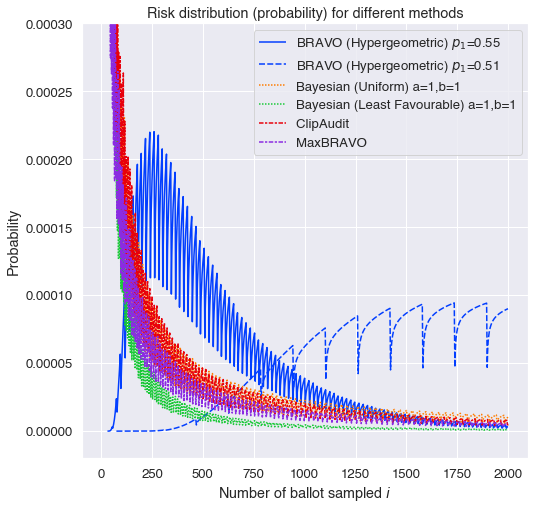

In [92]:
dash_styles = [(1, 0),
               (4, 1.5),
               (1, 1),
               (3, 1, 1.5, 1),
               (5, 1, 1, 1),
               (5, 1, 2, 1, 2, 1),
               (2, 2, 3, 1.5),
               (1, 2.5, 3, 1.2),
               (1, 0),
               (1, 0),
              ]
fig = plt.figure(figsize=[8,8])
ax = fig.add_subplot(111)
data = pdf_df050.query('parameter != "p=0.7" and basename_with_type != "Bayesian (Beta)" and  basename_with_type != "BRAVO (Binomial)"')
sns.lineplot(x='sample_count', 
             y='risk_pdf', 
             hue='basename_with_type', 
#              size='parameter', 
             style='parameter', 
             palette='bright',
#              sizes=(0.5,1.5),
             dashes=dash_styles, 
             data=data, 
             legend=False, ax=ax)
plt.ylim(-0.00002, 0.0003)
plt.xlabel('Number of ballot sampled $i$')
plt.ylabel('Probability')
plt.title('Risk distribution (probability) for different methods')
ax.legend(labels=[basename+" "+(parameter if 'p=' not in parameter else parameter.replace('p=','$p_1$=')) for i, (basename, parameter) in 
                  data[['basename_with_type', 'parameter']].drop_duplicates()
                  .iterrows()])

### CDF

In [82]:
cdf_df050 = cdf_df[[0.50]]
cdf_df050 = cdf_df050.reset_index()
cdf_df050.columns = ['method', 'sample_count', 'risk_cdf']
basenames = cdf_df050.method.apply(group_basename)
parameters = cdf_df050.method.apply(group_parameter)
basenames_with_type = cdf_df050.method.apply(group_basename_with_type)
parameters_with_type = cdf_df050.method.apply(group_parameter_with_type)
cdf_df050['basename'] = basenames
cdf_df050['basename_with_type'] = basenames_with_type
cdf_df050['parameter'] = parameters
cdf_df050['parameter_with_type'] = parameters_with_type
cdf_df050.head()

,method,sample_count,risk_cdf,basename,basename_with_type,parameter,parameter_with_type
0,bravo | p=0.7 | alpha=0.058559570312499996,0,0.0,BRAVO,BRAVO (Binomial),p=0.7,Binomial p=0.7
1,bravo | p=0.7 | alpha=0.058559570312499996,1,0.0,BRAVO,BRAVO (Binomial),p=0.7,Binomial p=0.7
2,bravo | p=0.7 | alpha=0.058559570312499996,2,0.0,BRAVO,BRAVO (Binomial),p=0.7,Binomial p=0.7
3,bravo | p=0.7 | alpha=0.058559570312499996,3,0.0,BRAVO,BRAVO (Binomial),p=0.7,Binomial p=0.7
4,bravo | p=0.7 | alpha=0.058559570312499996,4,0.0,BRAVO,BRAVO (Binomial),p=0.7,Binomial p=0.7


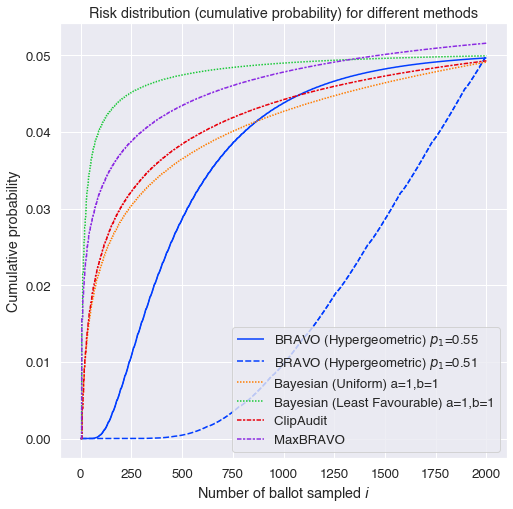

In [90]:
dash_styles = [(1, 0),
               (4, 1.5),
               (1, 1),
               (3, 1, 1.5, 1),
               (5, 1, 1, 1),
               (5, 1, 2, 1, 2, 1),
               (2, 2, 3, 1.5),
               (1, 2.5, 3, 1.2),
               (1, 0),
               (1, 0),
              ]
fig = plt.figure(figsize=[8,8])
ax = fig.add_subplot(111)
data = cdf_df050.query('parameter != "p=0.7" and basename_with_type != "Bayesian (Beta)" and  basename_with_type != "BRAVO (Binomial)"')
sns.lineplot(x='sample_count', 
             y='risk_cdf', 
             hue='basename_with_type', 
             style='parameter', 
             palette='bright',
             dashes=dash_styles, 
             data=data, 
             legend=False, ax=ax)
# plt.ylim(-0.0001, None)
plt.xlabel('Number of ballot sampled $i$')
plt.ylabel('Cumulative probability')
plt.title('Risk distribution (cumulative probability) for different methods')
ax.legend(labels=[basename+" "+(parameter if 'p=' not in parameter else parameter.replace('p=','$p_1$='))parameter for i, (basename, parameter) in 
                  data[['basename_with_type', 'parameter']].drop_duplicates()
                  .iterrows()], loc='lower right')